# Episode 12 — Implementing Classical Feedforward Logic and Conditional Execution

Dynamic circuits let a quantum program **react in real time** to mid-circuit measurements. In Qiskit v2.0, the API entry point is `QuantumCircuit.if_test`, which conditionally executes a body (and optionally an `else` body) based on classical bits or registers.

**What you'll learn**
- Mid-circuit measurement + classical feedforward
- `if_test` with a single classical bit
- `if_test` with an `else` branch
- Conditions on multi-bit classical registers
- Building classical expressions (e.g., parity) with `qiskit.circuit.classical.expr`
- Practical Runtime constraints and best practices

**Note**: On IBM Quantum hardware (Qiskit Runtime), support currently includes **conditional if statements**; other OpenQASM 3 control-flow features may not be available yet.

## 0. Environment & Utilities
This section installs optional extras (if needed) and defines helpers to **simulate** and **visualize** circuits locally. Execution of dynamic circuits on real hardware requires Qiskit Runtime with early-access features.

- `draw_circuit(qc)`: draws the circuit with Matplotlib if available.
- `run_counts(qc, shots)`: tries to simulate with Aer; falls back to a basic Sampler if Aer isn't installed (counts are approximated from quasi-probabilities).

In [8]:
# Optional: ensure visualization libraries are present (skip if already installed)
import importlib

have_matplotlib = importlib.util.find_spec("matplotlib") is not None
have_aer = importlib.util.find_spec("qiskit_aer") is not None

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from typing import Optional

def draw_circuit(qc: QuantumCircuit):
    if have_matplotlib:
        return qc.draw("mpl")
    else:
        print(qc.draw())

def run_counts(qc: QuantumCircuit, shots: int = 1024):
    """Try to get counts using Aer. If not available, approximate via Sampler quasi-probabilities.
    Note: mid-circuit measurement semantics are best tested with AerSimulator.
    """
    if have_aer:
        from qiskit_aer import AerSimulator
        sim = AerSimulator()
        tqc = QuantumCircuit()
        # For Aer, we can run qc directly
        job = sim.run(qc, shots=shots)
        result = job.result()
        if result.results and hasattr(result.results[0], 'data'):
            # standard counts pathway
            try:
                return result.get_counts()
            except Exception:
                pass
        # Fallback to quasi-probs if counts missing
        try:
            qis = result.get_quasi_dists()
            from collections import Counter
            c = Counter()
            for out, p in qis.items():
                c[out] += int(round(p * shots))
            return dict(c)
        except Exception:
            return {}
    else:
        # Approximate with Sampler if Aer isn't present (no strict mid-circuit semantics)
        try:
            from qiskit.primitives import Sampler
            sampler = Sampler()
            qpd = sampler.run([qc], shots=shots).result().quasi_dists[0]
            from collections import Counter
            c = Counter()
            for bitstr, p in qpd.items():
                c[bitstr] += int(round(p * shots))
            return dict(c)
        except Exception:
            print("Sampler not available; returning empty counts.")
            return {}

## 1. Single-bit conditional execution
Minimal dynamic circuit: measure, then conditionally correct. After the first measurement, if we read `1`, we apply `X` to flip back to `|0⟩`. The final measurement should be deterministic `0` in an ideal setting.

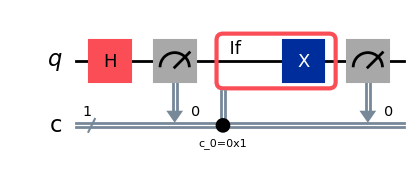

In [3]:
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
qc_single = QuantumCircuit(q, c)

qc_single.h(q[0])              # Step 1: create |+>
qc_single.measure(q[0], c[0])  # Step 2: mid-circuit measurement

with qc_single.if_test((c[0], 1)):
    qc_single.x(q[0])          # Step 3: corrective X if measured 1

qc_single.measure(q[0], c[0])  # Step 4: final readout

draw_circuit(qc_single)

In [9]:
counts_single = run_counts(qc_single, shots=1024)
counts_single

{'0': 1024}

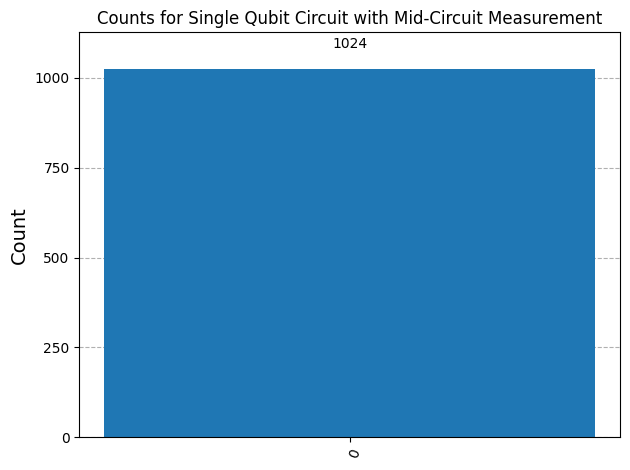

In [10]:
plot_histogram(
    counts_single,
    title="Counts for Single Qubit Circuit with Mid-Circuit Measurement"
    )

## 2. Conditional with else branch
Use the context-manager handle (`as otherwise`) to define an `else` block. If `c[0] == 1` we apply `H` to `q1`; otherwise we apply `X`.

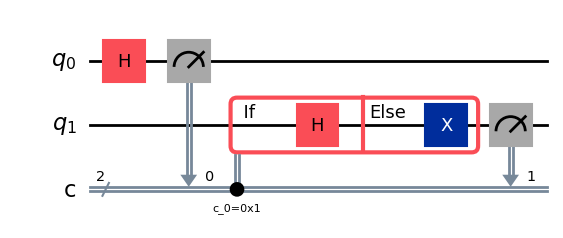

In [11]:
q = QuantumRegister(2, 'q')
c = ClassicalRegister(2, 'c')
qc_else = QuantumCircuit(q, c)

qc_else.h(q[0])
qc_else.measure(q[0], c[0])

with qc_else.if_test((c[0], 1)) as otherwise:
    qc_else.h(q[1])            # true branch
with otherwise:
    qc_else.x(q[1])            # false branch

qc_else.measure(q[1], c[1])
draw_circuit(qc_else)

In [13]:
counts_else = run_counts(qc_else, shots=1024)
counts_else

{'11': 264, '10': 504, '01': 256}

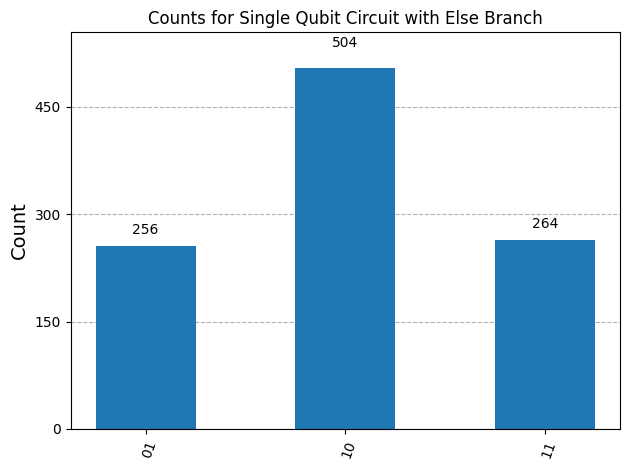

In [15]:
plot_histogram(
    counts_else,
    title="Counts for Single Qubit Circuit with Else Branch"
    )

## 3. Multi-bit register condition
Compare an entire classical register to an integer mask. Here, if `c == 0b001`, apply `X` to `q2`.

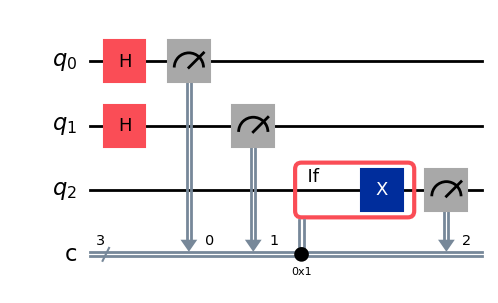

In [16]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(3, 'c')
qc_reg = QuantumCircuit(q, c)

qc_reg.h([q[0], q[1]])
qc_reg.measure(q[0], c[0])
qc_reg.measure(q[1], c[1])

with qc_reg.if_test((c, 0b001)):
    qc_reg.x(q[2])

qc_reg.measure(q[2], c[2])
draw_circuit(qc_reg)

In [18]:
counts_reg = run_counts(qc_reg, shots=2048)
counts_reg

{'101': 530, '011': 526, '000': 499, '010': 493}

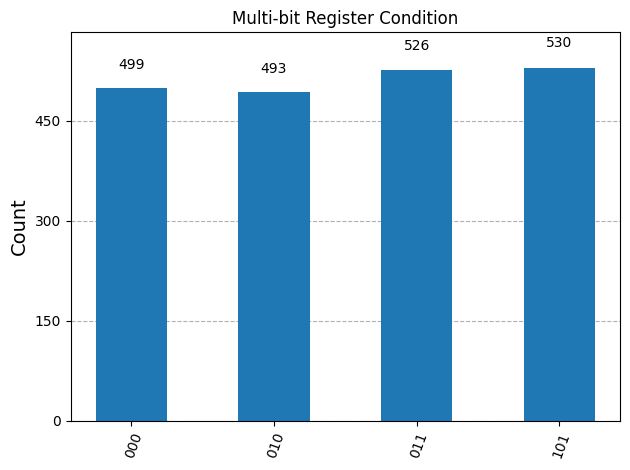

In [19]:
plot_histogram(
    counts_reg,
    title="Multi-bit Register Condition"
    )

## 4. Classical expressions: parity-driven control
Build expressions with `qiskit.circuit.classical.expr` to compose conditions such as parity. Below, we compute the parity of a subset of measurement bits and use it to control an `X` on a target qubit.

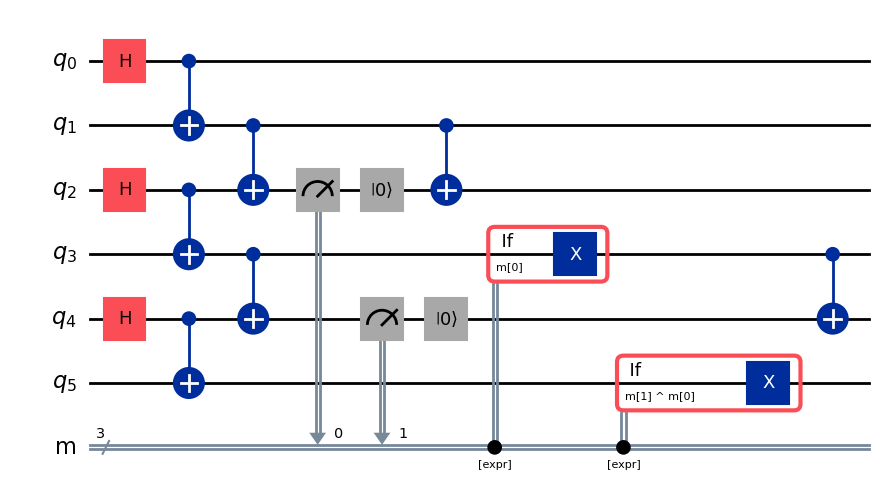

In [20]:
n = 6
q = QuantumRegister(n, 'q')
m = ClassicalRegister(n//2, 'm')  # measure boundary qubits
qc_expr = QuantumCircuit(q, m)

# 1) Create local Bell pairs: (0,1), (2,3), (4,5)
for i in range(0, n, 2):
    qc_expr.h(q[i])
    qc_expr.cx(q[i], q[i+1])

# 2) Glue pairs with CNOTs: (1->2), (3->4)
for i in range(1, n-1, 2):
    qc_expr.cx(q[i], q[i+1])

# 3) Measure boundary qubits and reset
boundary = [2, 4]
for k, qb in enumerate(boundary):
    qc_expr.measure(q[qb], m[k])
    qc_expr.reset(q[qb])

# 4) Parity-controlled X on unmeasured targets to stitch phases
for tgt in range(n):
    if tgt in boundary:
        continue
    left_ids = [k for k, qb in enumerate(boundary) if qb < tgt]
    if not left_ids:
        continue
    p = expr.lift(m[left_ids[0]])
    for k in left_ids[1:]:
        p = expr.bit_xor(m[k], p)
    with qc_expr.if_test(p):
        qc_expr.x(q[tgt])

# 5) Re-entangle measured qubits
for i in range(1, n-1, 2):
    qc_expr.cx(q[i], q[i+1])

draw_circuit(qc_expr)

### Task

Use the `run_counts` function to test with AerSimulator and plot the results with `plot_histogram`. If you want, you can try creating the simulator with `AerSimulator()`, create a job, and view the results without using the `run_counts` helper function.

**Solution**

<details>
<summary>Click to toggle to see the solution</summary>

```
counts_expr = run_counts(qc_expr, shots=2048)
plot_histogram(
    counts_expr,
    title="Counts for Single Qubit Circuit with Classical Expression"
    )
```
</details>

## 5. Qiskit Runtime constraints & best practices

**Hardware-oriented constraints** (as of 2025, subject to change):
- Only **conditional if** is supported on Runtime (no nested conditionals).
- Operand width for full-register compares: **≤ 32 bits**.
- **Broadcasted bits** per event: **≤ 60**. Separate independent conditionals with barriers.
- Avoid `measure` / `reset` **inside** conditional bodies.
- Arithmetic ops in conditions are not supported; build logic with `expr` combinators.

**Best practices**:
- Prefer single-bit conditions when possible (faster, fewer broadcasted bits).
- Use barriers to separate broadcasts.
- Prototype on simulators; then validate on Runtime.
- Keep conditional regions short to minimize latency.

## 6. Full demonstration: combined patterns
A compact example that shows single-bit conditionals, else branch, full-register compare, and expression-based control in the same flow.

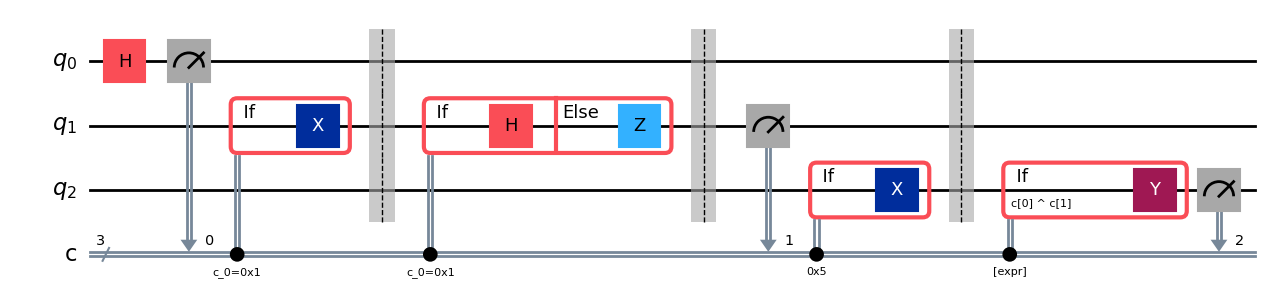

In [23]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(3, 'c')
qc_demo = QuantumCircuit(q, c)

# Single-bit conditional correction
qc_demo.h(q[0]); qc_demo.measure(q[0], c[0])
with qc_demo.if_test((c[0], 1)):
    qc_demo.x(q[1])

# Else branch driven by same bit (separate broadcast recommended)
qc_demo.barrier()
with qc_demo.if_test((c[0], 1)) as otherwise:
    qc_demo.h(q[1])
with otherwise:
    qc_demo.z(q[1])

# Register-based condition: if c == 0b101 then X on q2
qc_demo.barrier()
qc_demo.measure(q[1], c[1])
with qc_demo.if_test((c, 0b101)):
    qc_demo.x(q[2])

# Expression (parity) on c[0] ^ c[1]
qc_demo.barrier()
par = expr.bit_xor(c[0], c[1])
with qc_demo.if_test(par):
    qc_demo.y(q[2])

qc_demo.measure(q[2], c[2])
draw_circuit(qc_demo)

In [24]:
counts_demo = run_counts(qc_demo, shots=2048)
counts_demo

{'101': 554, '011': 505, '000': 989}

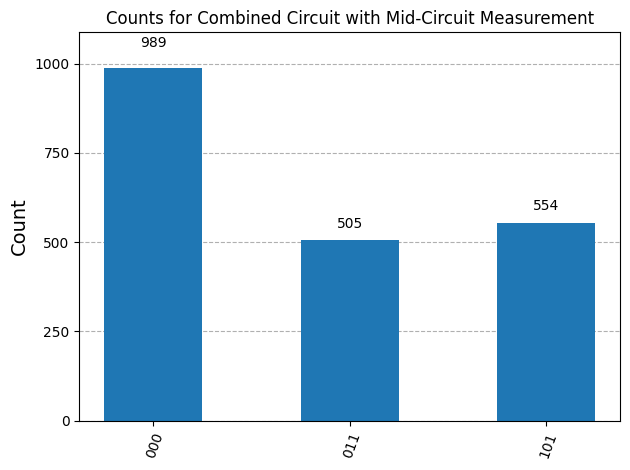

In [25]:
plot_histogram(
    counts_demo,
    title="Counts for Combined Circuit with Mid-Circuit Measurement"
)

## 7. Next steps
- Try swapping `X/H/Z/Y` for other gates to see how final distributions change.
- Increase register sizes and observe broadcast constraints.
- Port the patterns to Qiskit Runtime (early access) and measure latency effects.
- Compose these conditionals into **state-preparation** routines (e.g., GHZ, W) or **adaptive** algorithms.

## Additional information

**Created by:** Ricard Santiago Raigada García

**Version:** 1.0.0